## 0 Baseline – Logistic Regression with Full Pipeline


In [43]:
import pandas as pd, numpy as np
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate

# Load feature‑engineered data
DATA_DIR = Path("data")
train = pd.read_csv("titanic_train_fe.csv")
test  = pd.read_csv("titanic_test_fe.csv")


X = train.drop(columns=["Survived"])
y = train["Survived"]

# Feature groups
numeric_features = ["Age", "FarePerPerson", "TicketCount",
                    "Age_Pclass", "FPP_Pclass", "Age_Sex",
                    "Age_sq", "log_Fare", "log_FarePerPerson"]
ordinal_features = ["AgeBand", "FareBand", "FamilySizeBand"]
binary_features  = ["SexBin", "IsAlone"]
categorical_features = ["Pclass", "Embarked", "Deck",
                        "TitleGroup", "TicketPrefix",
                        "AgeBand_Sex", "Deck_Pclass"]

numeric_tf = Pipeline([("impute", SimpleImputer(strategy="median")),
                       ("scale",  StandardScaler())])

ordinal_tf = Pipeline([("impute", SimpleImputer(strategy="most_frequent"))])

categorical_tf = Pipeline([("impute", SimpleImputer(strategy="most_frequent")),
                           ("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer([
    ("num",  numeric_tf,       numeric_features),
    ("ord",  ordinal_tf,       ordinal_features),
    ("bin",  "passthrough",    binary_features),
    ("cat",  categorical_tf,   categorical_features)
])

baseline_model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier",   LogisticRegression(max_iter=1000, solver="lbfgs"))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(baseline_model, X, y, cv=cv,
                        scoring=["accuracy", "roc_auc"], n_jobs=-1)

print(f"CV Accuracy: {scores['test_accuracy'].mean():.4f}")
print(f"CV ROC‑AUC : {scores['test_roc_auc'].mean():.4f}")


CV Accuracy: 0.8148
CV ROC‑AUC : 0.8681


## 1 Model Zoo – Tree‑based Benchmarks
Evaluate Random Forest, Gradient Boosting, and (optionally) XGBoost with the same pre‑processing pipeline.


In [44]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
import xgboost as xgb   # pip install xgboost if not installed

models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=400, max_depth=None, min_samples_split=2,
        n_jobs=-1, random_state=42),
    
    "GradientBoosting": GradientBoostingClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=3,
        subsample=0.8, random_state=42),
    
    "XGBoost": xgb.XGBClassifier(
        n_estimators=500, learning_rate=0.05, max_depth=4,
        subsample=0.8, colsample_bytree=0.8,
        eval_metric="logloss", random_state=42, n_jobs=-1)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, clf in models.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("clf", clf)
    ])
    cv_scores = cross_validate(
        pipe, X, y, cv=cv,
        scoring=["accuracy", "roc_auc"], n_jobs=-1
    )
    results[name] = {
        "Accuracy": cv_scores["test_accuracy"].mean(),
        "ROC‑AUC": cv_scores["test_roc_auc"].mean()
    }

results_df = pd.DataFrame(results).T.round(4).sort_values("ROC‑AUC", ascending=False)
display(results_df)


,Accuracy,ROC‑AUC
RandomForest,0.8350,0.8813
GradientBoosting,0.8283,0.8802
XGBoost,0.8249,0.8767


## 2 Hyper‑parameter Tuning & SHAP Explainability


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best RF AUC: 0.8871
Best RF params: {'clf__max_depth': 10, 'clf__max_features': 0.7659979946695725, 'clf__min_samples_leaf': 7, 'clf__min_samples_split': 4, 'clf__n_estimators': 505}
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best XGB AUC: 0.8812
Best XGB params: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.05, 'clf__max_depth': 5, 'clf__n_estimators': 300, 'clf__subsample': 0.8}
Chosen model: RandomForestClassifier
✅ submission.csv saved
Performing SHAP analysis on RandomForestClassifier
SHAP values shape: (200, 98)
Feature data shape: (200, 98)
Number of feature names: 98


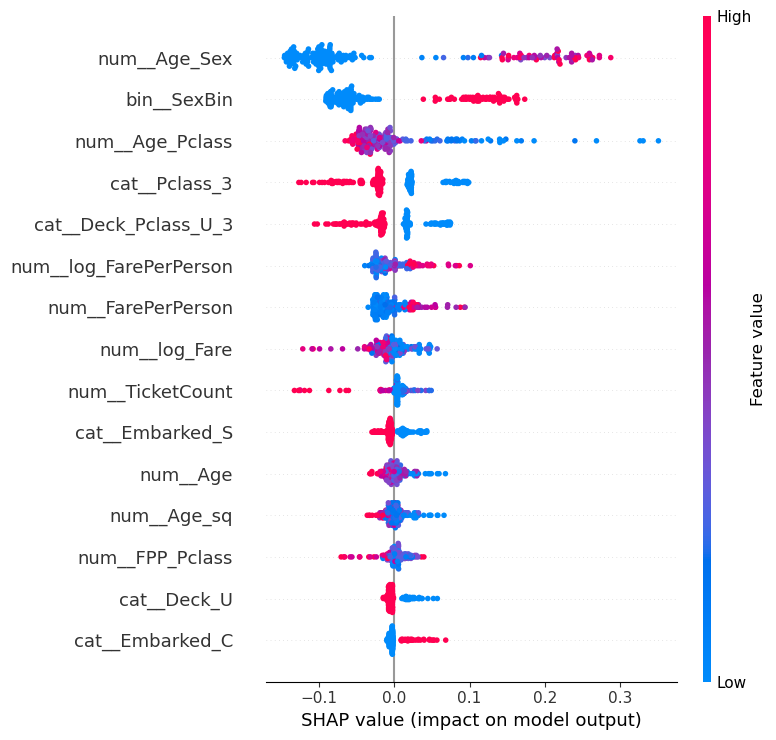

✅ SHAP summary plot saved as shap_summary.png


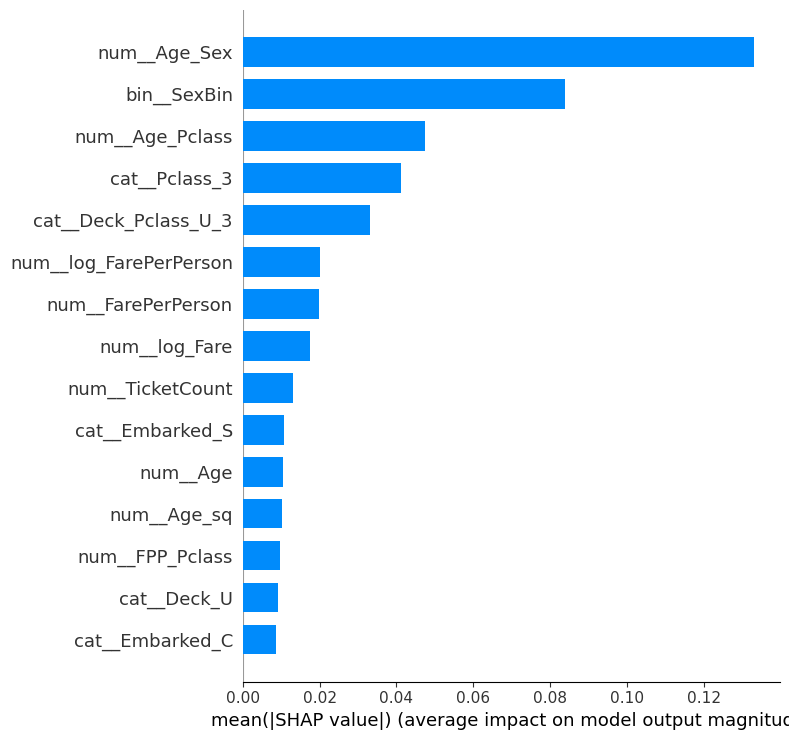

✅ SHAP importance plot saved as shap_importance.png


In [45]:
import pandas as pd, numpy as np, shap, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scipy.stats import randint, uniform

# ------------------- 0) Load data -------------------
DATA_DIR = Path("titanic")
test_ids = pd.read_csv(DATA_DIR / "test.csv", usecols=["PassengerId"])

train = pd.read_csv("titanic_train_fe.csv")
test  = pd.read_csv("titanic_test_fe.csv")

X = train.drop(columns=["Survived"])
y = train["Survived"]

# ------------------- 1) Tuning: Random Forest -------------------
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_dist = {
    "clf__n_estimators": randint(300, 800),
    "clf__max_depth": randint(4, 20),
    "clf__min_samples_split": randint(2, 10),
    "clf__min_samples_leaf": randint(1, 8),
    "clf__max_features": uniform(0.4, 0.6)  # fraction of features
}

rf_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", rf)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rs = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_dist,
    n_iter=30,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rs.fit(X, y)
print("Best RF AUC:", rs.best_score_.round(4))
print("Best RF params:", rs.best_params_)

best_rf_pipe = rs.best_estimator_

# ------------------- 2) Tuning: small grid for XGBoost (optional) -------------------
xgb_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", XGBClassifier(
        random_state=42, n_jobs=-1, eval_metric="logloss"
    ))
])

xgb_param_grid = {
    "clf__n_estimators": [300, 500],
    "clf__max_depth": [3, 5],
    "clf__learning_rate": [0.05, 0.1],
    "clf__subsample": [0.8, 1],
    "clf__colsample_bytree": [0.8, 1]
}

from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(
    xgb_pipe,
    param_grid=xgb_param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)
gs.fit(X, y)
print("Best XGB AUC:", gs.best_score_.round(4))
print("Best XGB params:", gs.best_params_)

best_xgb_pipe = gs.best_estimator_

# ------------------- 3) Choose the better model -------------------
final_pipe = best_rf_pipe if rs.best_score_ >= gs.best_score_ else best_xgb_pipe
print("Chosen model:", type(final_pipe.named_steps['clf']).__name__)

# ------------------- 4) Fit on full training data & predict test -------------------
final_pipe.fit(X, y)
test_pred = final_pipe.predict(test)

submission = pd.DataFrame({
    "PassengerId": test_ids["PassengerId"],
    "Survived": test_pred
})
submission.to_csv("submission.csv", index=False)
print("✅ submission.csv saved")

# ------------------- 5) SHAP global explanation (fixed version) -------------------
try:
    # Get the selected model for SHAP analysis
    chosen_model = final_pipe.named_steps["clf"]
    print(f"Performing SHAP analysis on {type(chosen_model).__name__}")
    
    # Create SHAP explainer
    if isinstance(chosen_model, (RandomForestClassifier, XGBClassifier)):
        explainer = shap.TreeExplainer(chosen_model)
    else:
        # For other model types, use KernelExplainer (more universal but slower)
        X_sample = final_pipe.named_steps["preprocessor"].transform(X[:100])
        if hasattr(X_sample, "toarray"):
            X_sample = X_sample.toarray()
        explainer = shap.KernelExplainer(chosen_model.predict_proba, X_sample)
    
    # Process feature data - use only first 200 samples for speed
    X_subset = X.iloc[:200]  # Use subset of original features
    X_processed = final_pipe.named_steps["preprocessor"].transform(X_subset)
    if hasattr(X_processed, "toarray"):  # Convert sparse matrix to dense
        X_processed = X_processed.toarray()
    X_processed = X_processed.astype(np.float32)
    
    # Get feature names
    try:
        feature_names = final_pipe.named_steps["preprocessor"].get_feature_names_out()
    except AttributeError:
        # If get_feature_names_out is not available, manually construct feature names
        feature_names = [f"feature_{i}" for i in range(X_processed.shape[1])]
    
    # Calculate SHAP values
    shap_values = explainer.shap_values(X_processed)
    
    # Fix SHAP plotting issues
    plt.figure(figsize=(12, 8))
    
    # For binary classification, handle shap_values if it's a list
    if isinstance(shap_values, list) and len(shap_values) == 2:
        shap_values_plot = shap_values[1]  # Positive class (Survived=1) SHAP values
    elif isinstance(shap_values, np.ndarray):
        if len(shap_values.shape) == 3:  # If 3D array, take positive class
            shap_values_plot = shap_values[:, :, 1]
        else:
            shap_values_plot = shap_values  # Single array
    else:
        shap_values_plot = shap_values
    
    # Ensure shape matching
    print(f"SHAP values shape: {shap_values_plot.shape}")
    print(f"Feature data shape: {X_processed.shape}")
    print(f"Number of feature names: {len(feature_names)}")
    
    # Ensure SHAP values and feature data have matching sample sizes
    min_samples = min(shap_values_plot.shape[0], X_processed.shape[0])
    shap_values_plot = shap_values_plot[:min_samples]
    X_processed_plot = X_processed[:min_samples]
    
    # Create SHAP summary plot
    shap.summary_plot(
        shap_values_plot, 
        X_processed_plot,
        feature_names=feature_names,
        show=False,
        max_display=15  # Show only top 15 important features
    )
    
    plt.tight_layout()
    plt.savefig("shap_summary.png", dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ SHAP summary plot saved as shap_summary.png")
    
    # Additional: Feature importance bar chart
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values_plot, 
        X_processed_plot,
        feature_names=feature_names,
        plot_type="bar",
        show=False,
        max_display=15
    )
    plt.tight_layout()
    plt.savefig("shap_importance.png", dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ SHAP importance plot saved as shap_importance.png")
    
except Exception as e:
    print(f"SHAP analysis error occurred: {str(e)}")
    print("Skipping SHAP analysis, but model training and prediction completed")
    import traceback
    traceback.print_exc()



The submission file above got a public score of 0.76794, which is slightly better than predicting all women surviving and all men perishing. Indicating there must be some data leaking or overfitting. We should try a simplier approach.

In [52]:
# titanic_lgbm_pipeline.py

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# ---------- 1. Load data ----------
train = pd.read_csv("titanic/train.csv")
test = pd.read_csv("titanic/test.csv")
test_passenger_ids = test["PassengerId"]
full = pd.concat([train, test], sort=False).reset_index(drop=True)

# ---------- 2. Basic Cleaning ----------
full["Embarked"].fillna(full["Embarked"].mode()[0], inplace=True)
full["Fare"].fillna(full[(full["Pclass"] == 3) & (full["Embarked"] == "S")]["Fare"].median(), inplace=True)
full["Age"].fillna(full["Age"].median(), inplace=True)

# ---------- 3. Feature Engineering ----------
full["FamilySize"] = full["SibSp"] + full["Parch"] + 1
full["IsAlone"] = (full["FamilySize"] == 1).astype(int)
full["Title"] = full["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)
full["Title"] = full["Title"].replace(["Mlle", "Ms", "Lady"], "Miss")
full["Title"] = full["Title"].replace(["Mme", "Dona"], "Mrs")
full["Title"] = full["Title"].replace(["Countess", "Capt", "Don", "Dr", "Major", "Rev", "Sir", "Jonkheer", "Col"], "Rare")

# Optional: simplify Cabin
full["Deck"] = full["Cabin"].str[0]
full["Deck"] = full["Deck"].fillna("U")

# ---------- 4. Encode Categorical ----------
cat_cols = ["Sex", "Embarked", "Title", "Deck"]
for col in cat_cols:
    le = LabelEncoder()
    full[col] = le.fit_transform(full[col].astype(str))

# ---------- 5. Split back ----------
train_clean = full.loc[full["Survived"].notnull()].copy()
test_clean = full.loc[full["Survived"].isnull()].copy()

X = train_clean.drop(["Survived", "Name", "Ticket", "Cabin", "PassengerId"], axis=1)
y = train_clean["Survived"].astype(int)
X_test = test_clean.drop(["Survived", "Name", "Ticket", "Cabin", "PassengerId"], axis=1)

# ---------- 6. LightGBM dataset ----------
categorical_feats = ["Sex", "Embarked", "Title", "Deck"]

lgb_train = lgb.Dataset(X, label=y, categorical_feature=categorical_feats)

# ---------- 7. Parameters ----------
params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "learning_rate": 0.03,
    "num_leaves": 31,
    "min_data_in_leaf": 20,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "random_state": 42
}

# ---------- 8. Cross Validation ----------
cv_result = lgb.cv(
    params,
    lgb_train,
    num_boost_round=5000,
    nfold=5,
    stratified=True,
    shuffle=True,
    callbacks=[lgb.early_stopping(100)],
    seed=42
)

best_iter = len(cv_result["valid auc-mean"])
print("✅ Best CV AUC:", round(cv_result["valid auc-mean"][-1], 5), "| Best Iteration:", best_iter)

# ---------- 9. Train final model ----------
final_model = lgb.train(
    params,
    lgb_train,
    num_boost_round=best_iter
)

# ---------- 10. Predict ----------
y_pred = final_model.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)  # default threshold

submission = pd.DataFrame({
    "PassengerId": test_passenger_ids,
    "Survived": y_pred_binary
})
submission.to_csv("submission_lgbm.csv", index=False)
print("✅ Saved: submission_lgbm.csv")


C:\Users\oudeb\AppData\Local\Temp\ipykernel_101796\2027337482.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full["Embarked"].fillna(full["Embarked"].mode()[0], inplace=True)
C:\Users\oudeb\AppData\Local\Temp\ipykernel_101796\2027337482.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 11
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 11
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[

Public Score:0.76076. Slightly worse than our previous submission.